# Denoising Autoencoder Training - Multi-Category

Trains a Denoising AE for each MVTec AD category.

**Key Feature:** Adds Gaussian noise during training to learn robust features.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, OUTPUTS_DIR, MVTEC_CATEGORIES, ensure_dirs
from src.data import create_mvtec_dataloaders
from src.models import create_denoising_ae
from src.training import get_optimizer, get_scheduler, EarlyStopping
from src.evaluation import plot_training_curves

ensure_dirs()
print(f"Device: {DEVICE}")

Device: cpu


## Configuration

In [2]:
CONFIG = {
    'batch_size': 16,
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'noise_factor': 0.3,  # Std of Gaussian noise
    'patience': 5,
    'save_every': 10,
}

CATEGORIES_TO_TRAIN = MVTEC_CATEGORIES
# CATEGORIES_TO_TRAIN = ['bottle']  # Uncomment for testing

print(f"Categories to train: {len(CATEGORIES_TO_TRAIN)}")
print(f"Noise factor: {CONFIG['noise_factor']}")

Categories to train: 15
Noise factor: 0.3


## Training Function

In [3]:
def train_dae_category(category):
    print(f"\n{'='*50}")
    print(f"Training Denoising AE: {category.upper()}")
    print(f"{'='*50}")
    
    # 1. Load Data
    try:
        train_loader, test_loader = create_mvtec_dataloaders(
            category, batch_size=CONFIG['batch_size'], return_mask=True
        )
    except Exception as e:
        print(f"Skipping {category}: {e}")
        return None
    
    # 2. Create Model
    model = create_denoising_ae(noise_factor=CONFIG['noise_factor']).to(DEVICE)
    optimizer = get_optimizer(model, lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = get_scheduler(optimizer, patience=2, factor=0.5)
    early_stopping = EarlyStopping(patience=CONFIG['patience'], mode='min')
    criterion = nn.MSELoss()
    
    # 3. Training Loop
    history = {'train_loss': []}
    
    for epoch in tqdm(range(1, CONFIG['num_epochs'] + 1), desc=f'{category}'):
        model.train()
        epoch_loss = 0.0
        
        for batch in train_loader:
            clean = batch[0].to(DEVICE)
            optimizer.zero_grad()
            
            # Forward: model adds noise internally during training
            recon, noisy = model(clean)
            
            # Loss: compare reconstruction to CLEAN input
            loss = criterion(recon, clean)
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        
        scheduler.step(avg_loss)
        
        if early_stopping(avg_loss):
            print(f"Early stopping at epoch {epoch}")
            break
    
    # 4. Evaluate
    model.eval()
    all_scores, all_labels = [], []
    with torch.no_grad():
        for img, mask, label in test_loader:
            img = img.to(DEVICE)
            scores = model.get_reconstruction_error(img, reduction='mean')
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(label.numpy())
    
    try:
        auc = roc_auc_score(all_labels, all_scores)
        print(f"{category.upper()} ROC-AUC: {auc:.4f}")
    except:
        auc = 0.0
    
    # 5. Save model
    save_path = MODELS_DIR / f'dae_{category}_final.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG,
        'history': history,
        'auc': auc,
    }, save_path)
    
    # 6. Plot training curves
    plot_training_curves(history, title=f'Denoising AE - {category}',
                         save_path=FIGURES_DIR / f'dae_{category}_training.png')
    plt.show()
    plt.close()
    
    return {'category': category, 'auc': auc, 'final_loss': history['train_loss'][-1]}

## Run Training Loop


Training Denoising AE: BOTTLE


bottle: 100%|██████████| 50/50 [07:56<00:00,  9.53s/it]


BOTTLE ROC-AUC: 0.5373


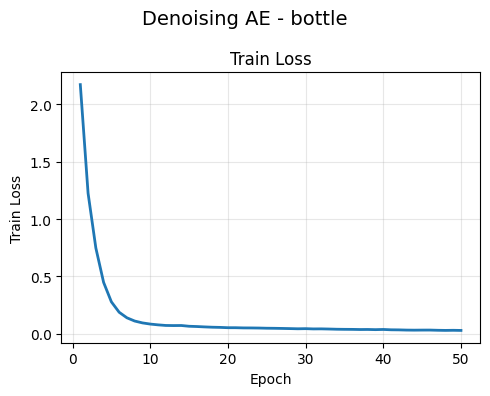


Training Denoising AE: CABLE


cable: 100%|██████████| 50/50 [11:15<00:00, 13.51s/it]


CABLE ROC-AUC: 0.4644


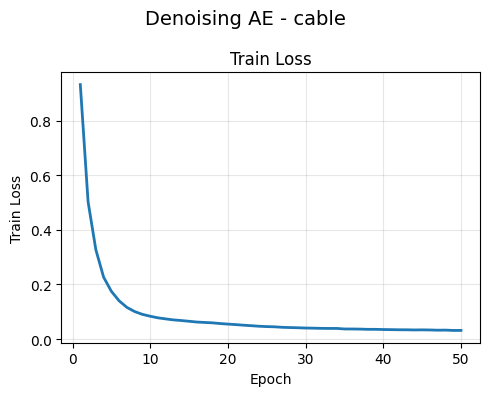


Training Denoising AE: CAPSULE


capsule: 100%|██████████| 50/50 [10:47<00:00, 12.94s/it]


CAPSULE ROC-AUC: 0.4659


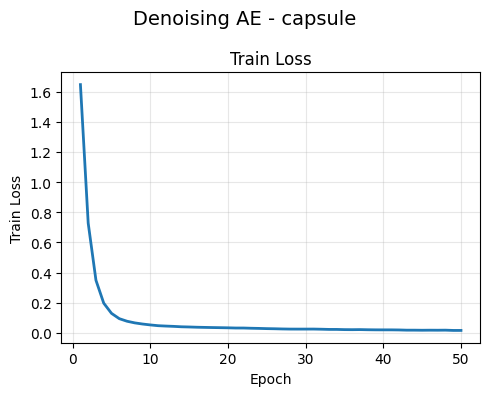


Training Denoising AE: CARPET


carpet: 100%|██████████| 50/50 [13:48<00:00, 16.57s/it]


CARPET ROC-AUC: 0.3319


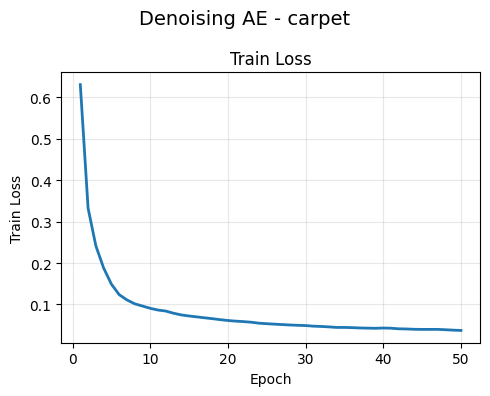


Training Denoising AE: GRID


grid: 100%|██████████| 50/50 [09:22<00:00, 11.24s/it]


GRID ROC-AUC: 0.8697


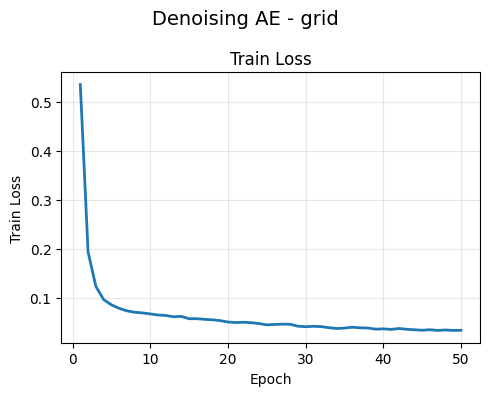


Training Denoising AE: HAZELNUT


hazelnut:  82%|████████▏ | 41/50 [16:01<03:31, 23.46s/it]

Early stopping at epoch 42


HAZELNUT ROC-AUC: 0.8879


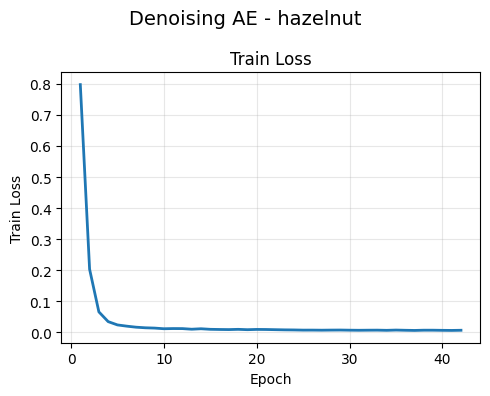


Training Denoising AE: LEATHER


leather:  74%|███████▍  | 37/50 [08:39<03:02, 14.03s/it]

Early stopping at epoch 38


LEATHER ROC-AUC: 0.3886


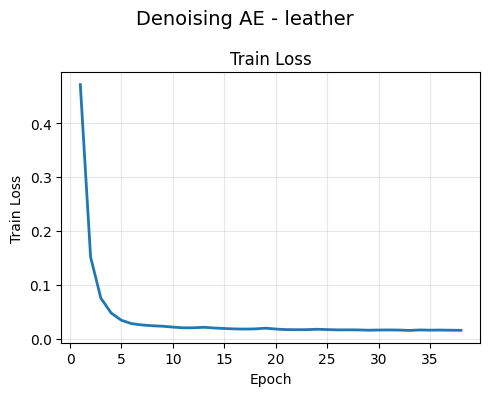


Training Denoising AE: METAL_NUT


metal_nut: 100%|██████████| 50/50 [07:32<00:00,  9.06s/it]


METAL_NUT ROC-AUC: 0.2683


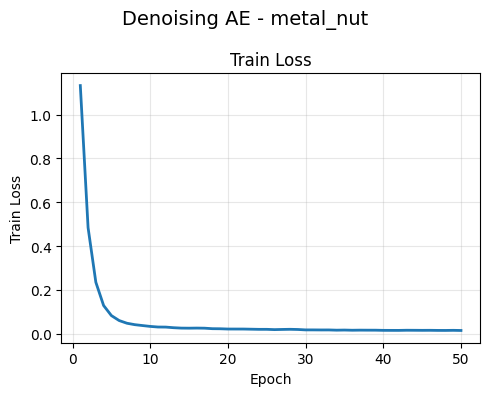


Training Denoising AE: PILL


pill: 100%|██████████| 50/50 [10:20<00:00, 12.42s/it]


PILL ROC-AUC: 0.7621


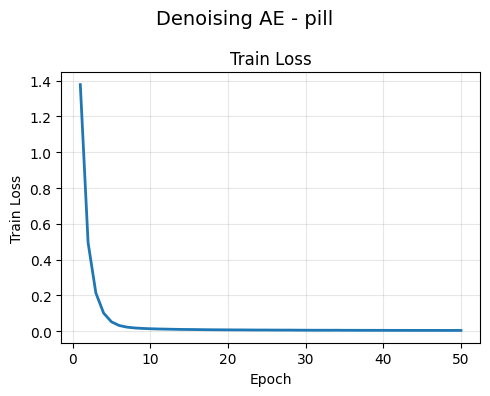


Training Denoising AE: SCREW


screw: 100%|██████████| 50/50 [11:16<00:00, 13.52s/it]


SCREW ROC-AUC: 0.9859


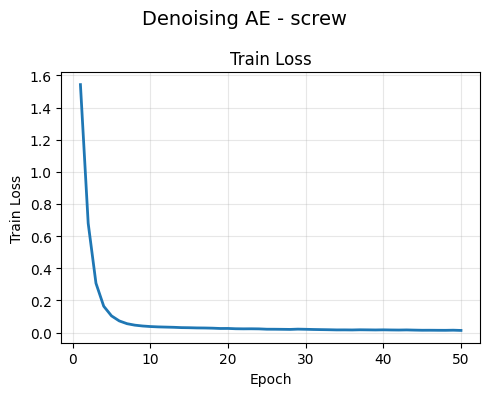


Training Denoising AE: TILE


tile: 100%|██████████| 50/50 [09:35<00:00, 11.51s/it]


TILE ROC-AUC: 0.8077


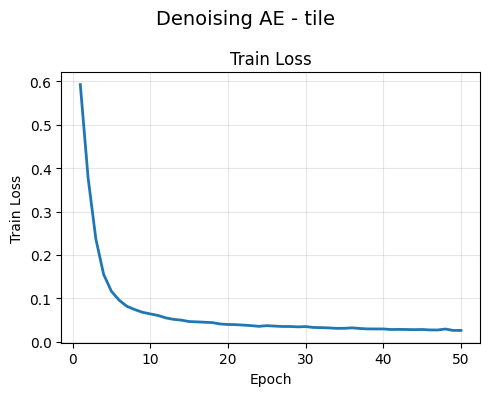


Training Denoising AE: TOOTHBRUSH


toothbrush: 100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


TOOTHBRUSH ROC-AUC: 0.6500


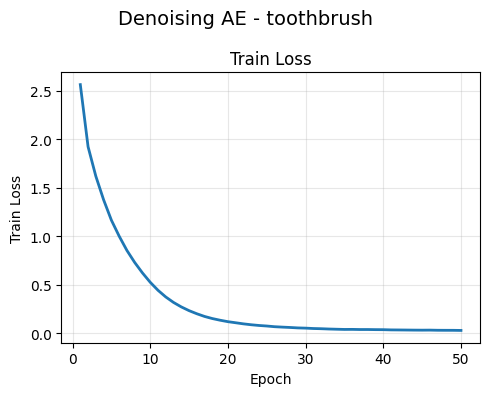


Training Denoising AE: TRANSISTOR


transistor: 100%|██████████| 50/50 [10:50<00:00, 13.00s/it]


TRANSISTOR ROC-AUC: 0.4450


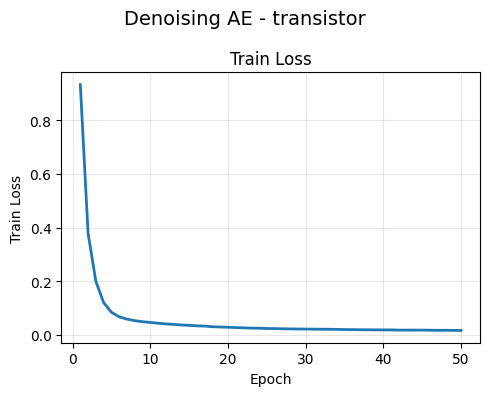


Training Denoising AE: WOOD


wood: 100%|██████████| 50/50 [12:33<00:00, 15.07s/it]


WOOD ROC-AUC: 0.9623


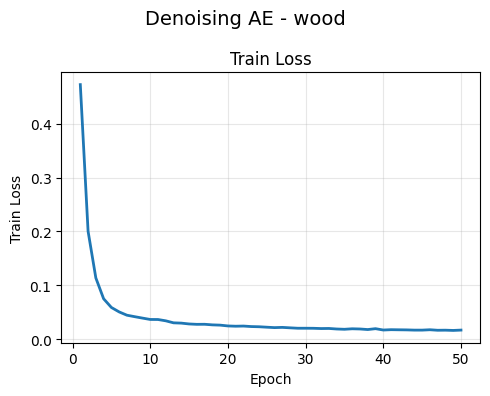


Training Denoising AE: ZIPPER


zipper: 100%|██████████| 50/50 [08:18<00:00,  9.98s/it]


ZIPPER ROC-AUC: 0.4874


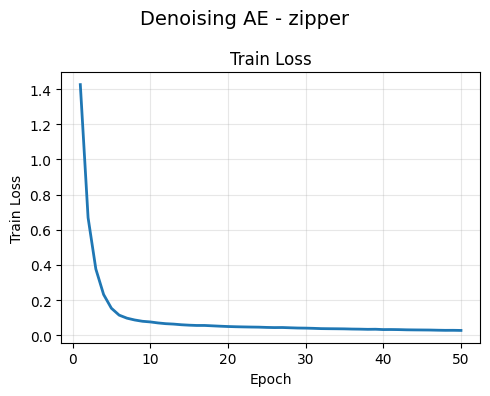


=== Denoising AE Results ===


,category,auc,final_loss
0,bottle,0.537302,0.030352
1,cable,0.464393,0.031624
2,capsule,0.465895,0.016497
3,carpet,0.331862,0.037352
4,grid,0.869674,0.033640
5,hazelnut,0.887857,0.006767
6,leather,0.388587,0.015638
7,metal_nut,0.268328,0.014653
8,pill,0.762139,0.004537
9,screw,0.985858,0.012977


In [4]:
results = []

for category in CATEGORIES_TO_TRAIN:
    res = train_dae_category(category)
    if res:
        results.append(res)

# Summary
df_results = pd.DataFrame(results)
if not df_results.empty:
    print("\n=== Denoising AE Results ===")
    display(df_results)
    df_results.to_csv(OUTPUTS_DIR / 'dae_mvtec_results.csv', index=False)